In [1]:
#import necessary packages for computation
import numpy as np
import xarray as xr
from scipy import stats,signal
import scipy.fftpack as fftpack
from scipy.interpolate import interp1d,CubicSpline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import cartopy.crs as ccrs
from math import *
from scipy.stats import pearsonr
import random
import warnings
import matplotlib.ticker as mticker
warnings.filterwarnings("ignore")
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
#from statsmodels.stats.multitest import fdrcorrection

In [2]:
#Import Function calculating the annomaly correlation coefficient
#Use .apply_ufunc instead of xarray automated (more efficient)
def acc_fun(f,o):
    subf = lambda x,y:x-y
    multf = lambda x,y: x*y
    sqf = lambda x:x**2
    radf = lambda x:x**0.5
    divf = lambda x,y:x/y
    
    fclim =  f.mean(dim = 'time')
    oclim = o.mean(dim = 'time')
    fanom = xr.apply_ufunc(subf, f, fclim)
    oanom = xr.apply_ufunc(subf, o, oclim)
    
    num = xr.apply_ufunc(multf,fanom,oanom).sum(dim='time')
    
    fanomsq = xr.apply_ufunc(sqf, fanom).sum(dim ='time')
    oanomsq = xr.apply_ufunc(sqf, oanom).sum(dim ='time')
    
    fanomrad = xr.apply_ufunc(radf, fanomsq)
    oanomrad = xr.apply_ufunc(radf, oanomsq)
    
    
    den = xr.apply_ufunc(multf, fanomrad,oanomrad)
    
    acc = xr.apply_ufunc(divf, num,den)
    return acc

In [3]:
#Function calculating the mean squared skill score
def mss_fun(f,o):
    squared_error = lambda x, y: (x - y) ** 2
    divf = lambda x,y:x/y
    
    oclim = o.mean(dim = 'time')

    num = xr.apply_ufunc(squared_error, f, o).sum(dim='time')
    den = xr.apply_ufunc(squared_error, o, oclim).sum(dim='time')
    mss = 1-xr.apply_ufunc(divf,num,den)
    return mss

In [4]:
#Function calculating the skill across ensembles
def ap_ensemble (f,o):
    acc_out=f.mean(dim='time').copy(deep=True)
    mss_out=f.mean(dim='time').copy(deep=True)
    for i in range(len(f.number.values)):
        f_cur=f.isel(number=i)
        acc_cur = acc_fun(f_cur,o)
        mss_cur=mss_fun(f_cur,o)
        acc_out[:,i]=acc_cur
        mss_out[:,i]=mss_cur
    return acc_out,mss_out

def pcor(x,y):
    return pearsonr(x, y)

In [5]:
%matplotlib inline

In [6]:
#Read forecast data 
forecast_data = {}
observed_data = {}
models = ['ecmwf','cma','hmcr','meteof']
for i in range(len(models)):
    observed_data[models[i]]=xr.open_dataset('v300/models/'+models[i]+'/output/nosmooth_era_nov_jan.nc')
    forecast_data[models[i]]=xr.open_dataset('v300/models/'+models[i]+'/output/nosmooth_'+models[i]+'_nov_jan.nc')

In [7]:
#fucntion to make yearly data 
def select_yrmo(df):
    dfsel=df.sel(time=slice('2002-11-10','2021-12-31'))
#     dfsel = dfsel.sel(time=dfsel.time.dt.month.isin([12,1,2]))
    return dfsel
def yearly_winters(df):
    fir =df.sel(time=df.time.dt.month.isin([12]))
    sec = df.sel(time=df.time.dt.month.isin([1,2]))

    years = list(set(fir.time.dt.year.values))
    years.sort()

    model_yy=xr.zeros_like(fir.sel(time = fir.time.dt.year==years[0]).mean(dim='time'))

    model_yu = model_yy[list(model_yy.keys())[0]].expand_dims(years = years).copy()

    for j in range(len(years)-1):
    #month 12
        modelfir = df.sel(time = df.time.dt.year==years[j])
        modelsec = df.sel(time = df.time.dt.year==years[j]+1)


        model_now=xr.concat([modelfir,modelsec],dim='time')
        model_mn = model_now.mean(dim = 'time')

        model_yu[j,]=model_mn[list(model_yy.keys())[0]].values
    return model_yu

## Temporal correlation between QSW and background conditions

In [16]:
#Read data
models=['ecmwf']

forecast_data = {}
observed_data = {}
#models = ['ecmwf']#,'cma','hmcr','meteof'
for i in range(1):
    observed_data[models[i]]=xr.open_dataset('v300/models/'+models[i]+'/output/nosmooth_era_nov_jan.nc')
    forecast_data[models[i]]=xr.open_dataset('v300/models/'+models[i]+'/output/nosmooth_'+models[i]+'_nov_jan.nc')

model_t2m_pac= xr.open_dataset('t2m/'+models[0]+'/output/t2m_'+models[0]+'_forecasted.nc')
model_block_pac= xr.open_dataset('new_gph/Blocking_forecasted_ecmwf.nc')
model_qsw=forecast_data[models[0]].q
model_qsw=model_qsw.sel(time=~((model_qsw.time.dt.month==11) &(model_qsw.time.dt.day.isin([3,7]))))

In [18]:
#smooth temp climatology for anom (5 init days ~2weeks) ; prep and cut up data (no smooth spatial)
model_qsw=rotlon(model_qsw)
model_t2m_pac=model_t2m_pac.sel(time=model_t2m_pac.time.dt.year.isin(np.arange(2002,2023)))

t2m_mod =model_t2m_pac.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))
t2m_mod=rotlon(t2m_mod)
t2m_modcl=t2m_mod.sortby(t2m_mod.time)

modyrs=np.arange(2002,2022)
t2m_clims=[]
t2m_fulls=[]
for i in modyrs:
    dat=t2m_modcl.sel(time=slice(str(i)+'-11-10',str(i+1)+'-02-28'))
    dat_sm=dat.rolling(time=5).mean().dropna(dim='time',how='all')
    t2m_clims.append(dat_sm)
    dat_full=t2m_modcl.sel(time=slice(str(i)+'-11-24',str(i+1)+'-02-20'))
    t2m_fulls.append(dat_full)
    

In [19]:
#calculate temp anoms
t2m_mod_clim=xr.concat(t2m_clims,dim='time')
t2m_mod_full=xr.concat(t2m_fulls,dim='time')
t2m_modanom=t2m_mod_full.groupby('time.dayofyear') - t2m_mod_clim.groupby('time.dayofyear').mean(dim='time')


In [20]:
#common timeperiods
model_qsw=model_qsw.sel(time=~((model_qsw.time.dt.month==11)&(model_qsw.time.dt.day<24)))
model_qsw=model_qsw.sel(time=~((model_qsw.time.dt.month==2)&(model_qsw.time.dt.day>20)))


In [21]:
#cut data and stack  (no spatial smoothing)

block_mod = model_block_pac.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))
block_mod=rotlon(block_mod)

ycutT2=t2m_modanom#.isel(latitude=slice(2,-2),longitude=slice(2,-2))
y1=ycutT2.stack(z={'latitude','longitude'})#.isel(years=slice(0,-1))
ycutBL=block_mod#.isel(latitude=slice(2,-2),longitude=slice(2,-2))
y2=ycutBL.stack(z={'latitude','longitude'})#.isel(years=slice(0,-1))


#QSW
yblock_mod=y2.sel(time=model_qsw.time)
yt2m_mod=y1.sel(time=model_qsw.time)



In [22]:
#get cold anomalies and stack remaining
yt2m_modneg=yt2m_mod.where(yt2m_mod<0)

modqsw_am=model_qsw.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))

x= modqsw_am.isel(step=slice(8,22))
# xlat = x.rolling(latitude=5,center=True).mean()
# xlon=xlat.rolling(longitude=5,center=True).mean()
xcut=x#lon.isel(latitude=slice(2,-2),longitude=slice(2,-2))
xstack=xcut.stack(z={'latitude','longitude'})

xstack_neg=xcut.stack(z={'latitude','longitude'}).where(yt2m_mod<0)

In [23]:
#sort time and average dimensions
y2_mod=yblock_mod.sortby(yblock_mod.time)
#y1_mod=y1_mod.sel(time=y1_mod.time.values[0::4]).load()

y1_mod=yt2m_modneg.sortby(yt2m_modneg.time)
#y2_mod=y2_mod.sel(time=y2_mod.time.values[0::4]).load()
x_mod1=xstack_neg.sortby(xstack.time).mean(dim=['step','number'])
x_mod2=xstack.sortby(xstack.time).mean(dim=['step','number'])

yy1_m=y1_mod.isel(step=slice(8,22)).mean(dim=['step','number'])
yy2_m=y2_mod.isel(step=slice(8,22)).mean(dim=['step','number'])

In [104]:
# temporal smooth monthly for all
yy1_mmo = yy1_m.resample(time="M").mean().dropna(dim='time',how='all')
yy2_mmo = yy2_m.resample(time="M").mean().dropna(dim='time',how='all')
x_mod1mo = x_mod1.resample(time="M").mean().dropna(dim='time',how='all')
x_mod2mo = x_mod2.resample(time="M").mean().dropna(dim='time',how='all')

yy1_mmo=yy1_mmo.sel(time=yy1_mmo.time.dt.month!=11)
yy2_mmo=yy2_mmo.sel(time=yy2_mmo.time.dt.month!=11)
x_mod1mo=x_mod1mo.sel(time=x_mod1mo.time.dt.month!=11)
x_mod2mo=x_mod2mo.sel(time=x_mod2mo.time.dt.month!=11)


In [105]:
#monthly smoothed correlation
rzt2m_m=yy1_mmo.t2m.copy(deep=True).isel(time=0)
pzt2m_m=yy1_mmo.t2m.copy(deep=True).isel(time=0)


rzblock_m=yy2_mmo.block.copy(deep=True).isel(time=0)
pzblock_m=yy2_mmo.block.copy(deep=True).isel(time=0)

for i in range(len(yy1_mmo.z)):
    ytemp=yy1_mmo.t2m[:,i].dropna(dim='time')
    xtemp=x_mod1mo.t2m[:,i].dropna(dim='time')
    try:
        cor1,corp1 = pcor(xtemp.values,ytemp.values)

        rzt2m_m[i] = cor1
        pzt2m_m[i] = corp1
    
    except:
        rzt2m_m[i] = np.nan
        pzt2m_m[i] = np.nan

    
for i in range(len(yy2_m.z)):
    yblock=yy2_mmo.block[:,i].dropna(dim='time')
    xblock=x_mod2mo[:,i].dropna(dim='time')
    try:
        cor4,corp4 = pcor(xblock.values,yblock.values)
        rzblock_m[i] = cor4
        pzblock_m[i] = corp4
    except:
        rzblock_m[i] = np.nan
        pzblock_m[i] = np.nan

In [106]:
#save correlation files
pzt2m_m.unstack().to_netcdf('t2m_pvals_monthlyall_climsmoothed_Mampl2.nc')
pzblock_m.unstack().to_netcdf('block_pvals_monthlyall_climsmoothed_Mampl2.nc')

rzt2m_m.unstack().to_netcdf('t2m_corr_monthlyall_climsmoothed_Mampl2.nc')
rzblock_m.unstack().to_netcdf('block_corr_monthlyall_climsmoothed_Mampl2.nc')

In [93]:
#read era5 dat
t2m_era = xr.open_dataset('t2m/era5/era5_daily_t2m_1990-2022.nc')
blockera = xr.open_dataset('new_gph/Blocking_observed_final_era5.nc')
qswera = xr.open_dataset('predict/ERA5_Q_1.5_Winter.nc')


In [94]:
#smooth climatology and calc anom
t2m_erasm=t2m_era.rolling(time=14).mean().dropna(dim='time',how='all')
t2m_erafull=t2m_era.sel(time=t2m_erasm.time)
t2mera_anom=t2m_erafull.groupby('time.dayofyear') - t2m_erasm.groupby('time.dayofyear').mean(dim='time')

In [95]:
#get common time
qswera=xr.where(~((qswera.time.dt.month==11) &(qswera.time.dt.day.isin([3,7]))),qswera,np.nan).dropna(dim='time')
qswera=qswera.sel(time=slice('2002-11-10','2022-02-09'))

qswera=rotlon(qswera)

In [96]:
#prep data no spatial smooth
blockera=blockera.sel(time=qswera.time)
t2mera=t2mera_anom.sel(time=qswera.time)

blockera=rotlon(blockera)
t2mera=rotlon(t2mera)


qsw_cut = qswera.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))
t2m_cut = t2mera.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))
block_cut = blockera.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))

t2msliced=t2m_cut#.isel(latitude=slice(2,-2),longitude=slice(2,-2))
y1o=t2msliced.stack(z={'latitude','longitude'})#.isel(years=slice(0,-1))
blocksliced=block_cut#.isel(latitude=slice(2,-2),longitude=slice(2,-2))
y2o=blocksliced.stack(z={'latitude','longitude'})#.isel(years=slice(0,-1))

y1o_neg=y1o.where(y1o<0)

x= qsw_cut.q#.isel(step=slice(8,22)).mean(dim=['step'])
# xlat = x.rolling(latitude=5,center=True).mean()
# xlon=xlat.rolling(longitude=5,center=True).mean()
xcut=x#lon.isel(latitude=slice(2,-2),longitude=slice(2,-2))
xstack=xcut.stack(z={'latitude','longitude'})

xstackneg=xcut.stack(z={'latitude','longitude'}).where(y1o<0)



In [99]:
#Only overlapping times
y2o=y2o.sel(time=((y2o.time.dt.month!=11) & (y2o.time.dt.year!=2023)))
y2o=y2o.sortby(y2o.time).sel(time=slice('2002-12-01','2022-02-09'))
#y2o.time.values#.time.sortby(y2o.time).values

y1o_negt=y1o_neg.sel(time=((y1o_neg.time.dt.month!=11) & (y1o_neg.time.dt.year!=2023)))
y1o_negt=y1o_negt.sortby(y1o_negt.time).sel(time=slice('2002-12-01','2022-02-09'))
#y1o.time.values#.time.sortby(y1o.time).values

xstack=xstack.sortby(xstack.time)
# xstack=xstack.sel(time=slice('2002-11-10','2022-02-09'))
# xstack=xstack.sel(time=~((xstack.time.dt.month==2)&(xstack.time.dt.day>9))).sortby(xstack.time)
xstack=xstack.sel(time=y2o.time)

xstackneg=xstackneg.sortby(xstackneg.time)

In [101]:
##temporal smooth monthly all
yy1_omo = y1o_negt.resample(time="M").mean().dropna(dim='time',how='all')
yy2_omo = y2o.resample(time="M").mean().dropna(dim='time',how='all')
x_o1mo = xstackneg.resample(time="M").mean().dropna(dim='time',how='all')
x_o2mo = xstack.resample(time="M").mean().dropna(dim='time',how='all')



In [109]:
#correlate

rzt2m_o=yy1_omo.t2m.copy(deep=True).isel(time=0)
pzt2m_o=yy1_omo.t2m.copy(deep=True).isel(time=0)


rzblock_o=yy2_omo.block.copy(deep=True).isel(time=0)
pzblock_o=yy2_omo.block.copy(deep=True).isel(time=0)

for i in range(len(yy1_omo.z)):
    ytemp=yy1_omo.t2m[:,i].dropna(dim='time')
    xtemp=x_o1mo.t2m[:,i].dropna(dim='time')
    try:
        cor1,corp1 = pcor(xtemp.values,ytemp.values)
        rzt2m_o[i] = cor1
        pzt2m_o[i] = corp1
    
    except:
        rzt2m_o[i] = np.nan
        pzt2m_o[i] = np.nan

    
for i in range(len(yy2_omo.z)):
    yblock=yy2_omo.block[:,i].dropna(dim='time')
    xblock=x_o2mo[:,i].dropna(dim='time')
    try:
        cor4,corp4 = pcor(xblock.values,yblock.values)
        rzblock_o[i] = cor4
        pzblock_o[i] = corp4
    except:
        rzblock_o[i] = np.nan
        pzblock_o[i] = np.nan

In [110]:
#save to files
pzt2m_o.unstack().to_netcdf('t2m_pvals_monthlyall_climsmoothed_Oampl2.nc')
pzblock_o.unstack().to_netcdf('block_pvals_monthlyall_climsmoothed_Oampl2.nc')

rzt2m_o.unstack().to_netcdf('t2m_corr_monthlyall_climsmoothed_Oampl2.nc')
rzblock_o.unstack().to_netcdf('block_corr_monthlyall_climsmoothed_Oampl2.nc')

In [3]:
#read files back
pzt2m_o=xr.open_dataset('t2m_pvals_monthlyall_climsmoothed_Oampl2.nc').t2m
pzblock_o=xr.open_dataset('block_pvals_monthlyall_climsmoothed_Oampl2.nc').block

pzt2m_m=xr.open_dataset('t2m_pvals_monthlyall_climsmoothed_Mampl2.nc').t2m
pzblock_m=xr.open_dataset('block_pvals_monthlyall_climsmoothed_Mampl2.nc').block

rzt2m_o=xr.open_dataset('t2m_corr_monthlyall_climsmoothed_Oampl.nc').t2m
rzblock_o=xr.open_dataset('block_corr_monthlyall_climsmoothed_Oampl.nc').block

rzt2m_m=xr.open_dataset('t2m_corr_monthlyall_climsmoothed_Mampl.nc').t2m
rzblock_m=xr.open_dataset('block_corr_monthlyall_climsmoothed_Mampl.nc').block

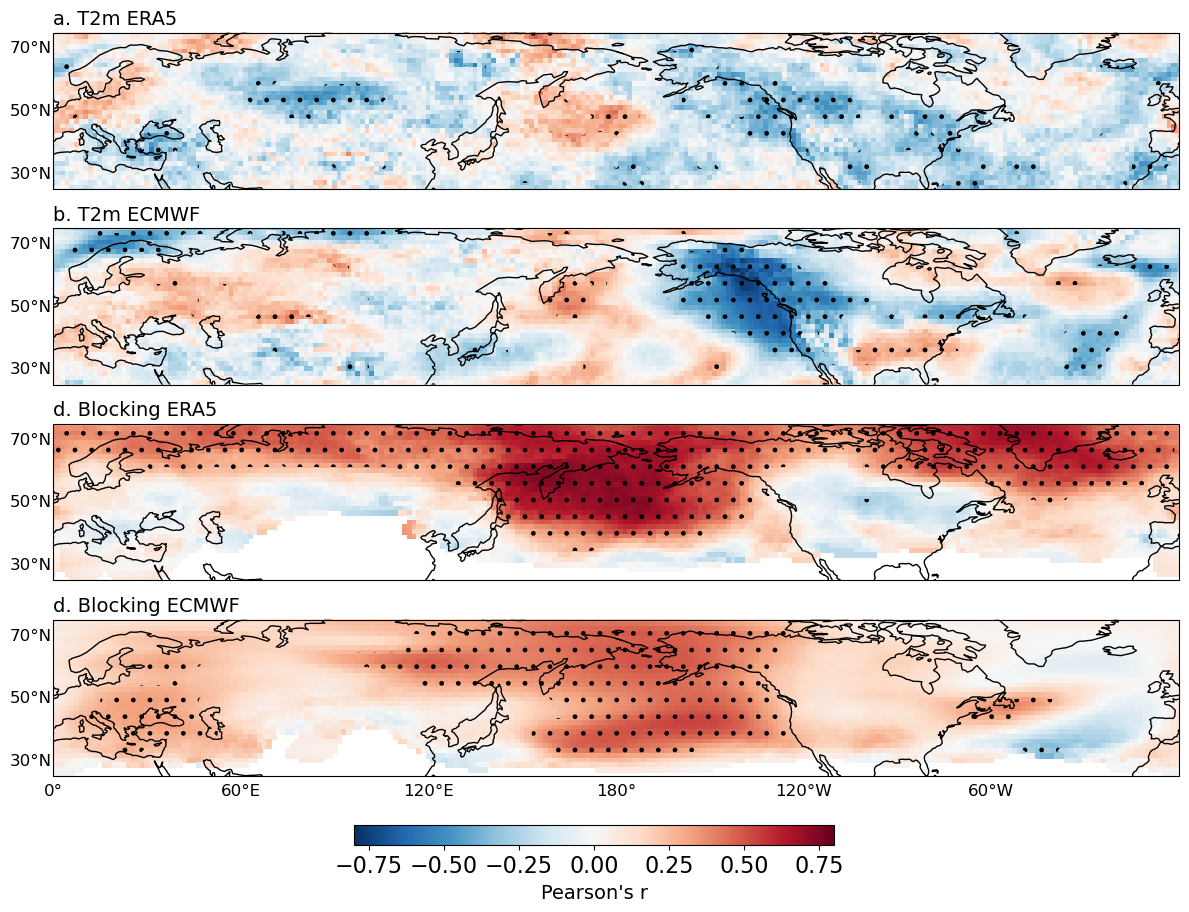

In [115]:
#Plot
lets=['a. ','b. ','c. ', 'd. ']
fig=plt.figure(figsize=(12,10))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)



ax=fig.add_subplot(411,projection=proj)
cor=rzt2m_o.unstack()
pval = pzt2m_o#.unstack()

# cor=cor.sel(longitude=slice(90,270))
# pval=pval.sel(longitude=slice(90,270))
#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
cor.plot(x='longitude',y='latitude',vmax=0.8,vmin=-0.8, ax=ax, cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#sst_y1.sst.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[0]+'T2m ERA5', fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()
#ax.set_xlim([-90,90]) 
ax.set_ylim([25,75]) 

ax=fig.add_subplot(412,projection=proj)
cor=rzt2m_m.unstack()
pval = pzt2m_m#.unstack()

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#t2msliced.t2m.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[1]+'T2m ECMWF',fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()

#ax.set_xlim([-90,90])
ax.set_ylim([25,75]) 

ax=fig.add_subplot(413,projection=proj)
cor=rzblock_o.unstack()
pval = pzblock_o#.unstack()

# cor=cor.sel(longitude=slice(90,270))
# pval=pval.sel(longitude=slice(90,270))

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)


m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#u_y1.u.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(-30,90,15), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[3]+'Blocking ERA5', fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.ylabels_left = False
gl.xlabels_bottom = False
ax.coastlines()
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
#ax.set_xlim([-90,90]) 
ax.set_ylim([25,75]) 

ax=fig.add_subplot(414,projection=proj)
cor=rzblock_m.unstack()
pval = pzblock_m#.unstack()
#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)


# ax.set_xlim([-30,90])
m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#yu1.u.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(-30,90,15), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[3]+'Blocking ECMWF',fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
# gl.xlabels_left = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()
#ax.set_xlim([-90,90]) 
ax.set_ylim([25,75])  
# cbar_ax = fig.add_axes([0.25, 0.5, 0.5, 0.02])
# fig.colorbar(m, cax=cbar_ax,orientation='horizontal',label="Pearson's r")

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="Pearson's r",size=14)
cbl.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, bottom=0.2)

# plt.tight_layout()
plt.savefig('plots/QSW_vs_extremes_ecmwf_era_cor_allmonthly_nospatial_climsmoothed2.png')
plt.show()


In [116]:
#read fdr corrected files
pzt2m_o=xr.open_dataset('t2m_pvals_monthlyall_climsmoothed_Oampl_fdr2.nc').t2m
pzblock_o=xr.open_dataset('block_pvals_monthlyall_climsmoothed_Oampl_fdr2.nc').block

pzt2m_m=xr.open_dataset('t2m_pvals_monthlyall_climsmoothed_Mampl_fdr2.nc').t2m
pzblock_m=xr.open_dataset('block_pvals_monthlyall_climsmoothed_Mampl_fdr2.nc').block

In [ ]:
#plot (fdr corrected)
lets=['a. ','b. ','c. ', 'd. ']
fig=plt.figure(figsize=(12,10))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)



ax=fig.add_subplot(411,projection=proj)
cor=rzt2m_o.unstack()
pval = pzt2m_o#.unstack()

# cor=cor.sel(longitude=slice(90,270))
# pval=pval.sel(longitude=slice(90,270))
#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
cor.plot(x='longitude',y='latitude',vmax=0.8,vmin=-0.8, ax=ax, cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#sst_y1.sst.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[0]+'T2m ERA5', fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()
#ax.set_xlim([-90,90]) 
ax.set_ylim([25,75]) 

ax=fig.add_subplot(412,projection=proj)
cor=rzt2m_m.unstack()
pval = pzt2m_m#.unstack()

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#t2msliced.t2m.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[1]+'T2m ECMWF',fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()

#ax.set_xlim([-90,90])
ax.set_ylim([25,75]) 

ax=fig.add_subplot(413,projection=proj)
cor=rzblock_o.unstack()
pval = pzblock_o#.unstack()

# cor=cor.sel(longitude=slice(90,270))
# pval=pval.sel(longitude=slice(90,270))

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)


m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#u_y1.u.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(-30,90,15), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[3]+'Blocking ERA5', fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.ylabels_left = False
gl.xlabels_bottom = False
ax.coastlines()
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
#ax.set_xlim([-90,90]) 
ax.set_ylim([25,75]) 

ax=fig.add_subplot(414,projection=proj)
cor=rzblock_m.unstack()
pval = pzblock_m#.unstack()
#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)


# ax.set_xlim([-30,90])
m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#yu1.u.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(-30,90,15), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[3]+'Blocking ECMWF',fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
# gl.xlabels_left = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()
#ax.set_xlim([-90,90]) 
ax.set_ylim([25,75])  
# cbar_ax = fig.add_axes([0.25, 0.5, 0.5, 0.02])
# fig.colorbar(m, cax=cbar_ax,orientation='horizontal',label="Pearson's r")

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="Pearson's r",size=14)
cbl.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, bottom=0.2)

# plt.tight_layout()
plt.savefig('plots/QSW_vs_extremes_ecmwf_era_cor_allmonthly_nospatial_climsmoothed_FDR2.png')
plt.show()


## MJO, ENSO, SSW composites

In [15]:
#Bootstrap functions for each composites
import random
#Bootstrap datasets with equal subset https://www.nature.com/articles/s41467-023-41551-9#Sec7
def bootstrap(fo,ob, number):
    iterations= 1000 #attempt
    
    times=ob.time.values

    outdat = ob.isel(time=0).expand_dims(sample=np.arange(1,iterations+1)).copy()
    #print(outdat)
    for i in range(iterations):
        topy_rand=random.sample(sorted(times), number)
        #print(topy_rand)
        fo_boot = fo.sel(time=fo.time.isin(topy_rand)).mean(dim='number')
        ob_boot = ob.sel(time=ob.time.isin(topy_rand))

        acc_top=acc_new(fo_boot,ob_boot)
        #print(acc_top)
        outdat[i,]=acc_top.values


    return outdat

def bootstrap_sst(fo,ob, init_yrs):
    #bootstrap by year swap
    iterations= 1000#attempt
    
    times=ob.time.values

    outdat = ob.isel(time=0).expand_dims(sample=np.arange(1,iterations+1)).copy()
    #print(outdat)
    for k in range(iterations):
        year_pool=sorted(np.unique(ob.time.dt.year.values))
        sample_dates=[]
        for i in init_yrs.values():
            y=random.sample(year_pool,1)
            for j in i:
                date=f"{y[0]}-"+j
                sample_dates.append(np.datetime64(date))

        #print(topy_rand)
        fo_boot = fo.sel(time=fo.time.isin(sample_dates)).mean(dim='number')
        ob_boot = ob.sel(time=ob.time.isin(sample_dates))

        acc_top=acc_new(fo_boot,ob_boot)
        #print(acc_top)
        outdat[k,]=acc_top.values


    return outdat

def bootstrap_ssw(fo,ob, init_yrs):
    #bootstrap by year swap
    iterations= 1000#attempt
    
    times=ob.time.values

    outdat = ob.isel(time=0).expand_dims(sample=np.arange(1,iterations+1)).copy()
    #print(outdat)
    for k in range(iterations):
        year_pool=sorted(np.unique(ob.time.dt.year.values))
        sample_dates=[]
        for i in init_yrs.values():
            y=random.sample(year_pool,1)
            for j in i:
                date=f"{y[0]}-"+j
                sample_dates.append(np.datetime64(date))

        #print(topy_rand)
        fo_boot = fo.sel(time=fo.time.isin(sample_dates)).mean(dim='number')
        ob_boot = ob.sel(time=ob.time.isin(sample_dates))

        acc_top=acc_new(fo_boot,ob_boot)
        #print(acc_top)
        outdat[k,]=acc_top.values


    return outdat

def significance(bootdat,sample):

    sig=xr.where(np.abs(bootdat)>=np.abs(sample),1,0)
    outsig=sig.mean(dim='sample')
    
    return outsig



### MJO

In [8]:
#read anomally data
models11 = ['ecmwf']

anom_models={}
anom_obs={}

for i in range(1):
    anom_models[models11[i]]=xr.open_dataset('forecaset_'+models11[i]+'_qsw_anomallies.nc').q
    anom_obs[models11[i]]=xr.open_dataset('observed_'+models11[i]+'_qsw_anomallies.nc').q

In [9]:
#read mjo data and select same dates
mjo = xr.open_dataset('predict/MJO_indices_1979-2024.nc')
# mjo_sel=select_yrmo(mjo)
mjo_timesorted=mjo.sortby(mjo.time)

mjo_i={}
# for i in range(len(models11)):
for i in range(1):
    ob_sel=anom_obs[models11[i]].sel(time=~((anom_obs[models11[i]].time.dt.month==11) & (anom_obs[models11[i]].time.dt.day<10)))
    ob_sel2=ob_sel.sel(time=ob_sel.time.dt.year<2022)
    ob_timesorted=ob_sel2.sortby(ob_sel2.time)

    #resample every week 
    ob_resampled=ob_timesorted.sel(time=ob_timesorted.time.values[0::2]) ##every other data
    mjo_initdates=mjo_timesorted.sel(time=ob_resampled.time)
    mjo_i[models11[i]]=mjo_initdates

In [12]:
#Get data for each MJO phase, calculate skill
acc_modphases={}
sample_mods={}
obs_phases={}
std_phases={}
# for i in range(len(models11)):
for i in range(1):
    acc_phase=[]
    obs_phase=[]
    std_phase=[]
    sample_sizes=[]
    sample_times=[]
    for j in range(8):
        mjo_cur=mjo_i[models11[i]].where(mjo_i[models11[i]].Phase.isin([j+1])).dropna(dim='time')

        o_cur=anom_obs[models11[i]].sel(time=mjo_cur.time)
        f_cur=anom_models[models11[i]].sel(time=mjo_cur.time).mean(dim='number')

        sample_sizes.append(len(mjo_cur.time.values))
        sample_times.append(mjo_cur.time.values)
        acc_cur=acc_fun(f_cur,o_cur)
        acc_phase.append(acc_cur)
        obs_phase.append(o_cur.mean(dim='time'))
        std_phase.append(o_cur.std(dim='time'))
    acc_modphases[models11[i]]=acc_phase
    sample_mods[models11[i]]=sample_sizes
    obs_phases[models11[i]]=obs_phase
    std_phases[models11[i]]=std_phase

In [16]:
#apply bootstrap to skill
sig_mods={}
# for i in range(len(models11)):
for i in range(1):
    significances=[]
    highcons=[]
    lowcons=[]
    for j in range(8):
        fo=anom_models[models11[i]].isel(step=slice(6,21))
        ob=anom_obs[models11[i]].isel(step=slice(6,21))
        bootdatout=bootstrap(fo,ob,sample_mods[models11[i]][j])
        bootdat=bootdatout.mean(dim=['step'])

        accphasei=acc_modphases[models11[i]][j].isel(step=slice(6,21)).mean(dim=['step'])
        sig=significance(bootdat,accphasei)
        conlo,conhi=confidence(bootdat)
        significances.append(sig)
        highcons.append(conhi)
        lowcons.append(conlo)
        bootdat.to_netcdf('bootdat_mjo_phase'+str(j+1)+'1000x.nc')
        sig.to_netcdf('p-vals_mjo_phase'+str(j+1)+'1000x.nc')
    sig_mods[models11[i]]=significances
    

In [42]:
#Calculate significance levels
sig_mods={}
# for i in range(len(models11)):
for i in range(1):
    significances=[]
    for j in range(8):
        sigm=xr.open_dataset('p-vals_mjo_phase'+str(j+1)+'_1000x_fdr.nc')
        significances.append(sigm.q)
    sig_mods[models11[i]]=significances

In [37]:
#calculate difference from mean
acc_mn={}
# for i in range(len(models11)):
for i in range(1):
    acc_mean=acc_new(anom_models[models11[i]].mean(dim='number'),anom_obs[models11[i]])
    acc_mn[models11[i]]=acc_mean
    


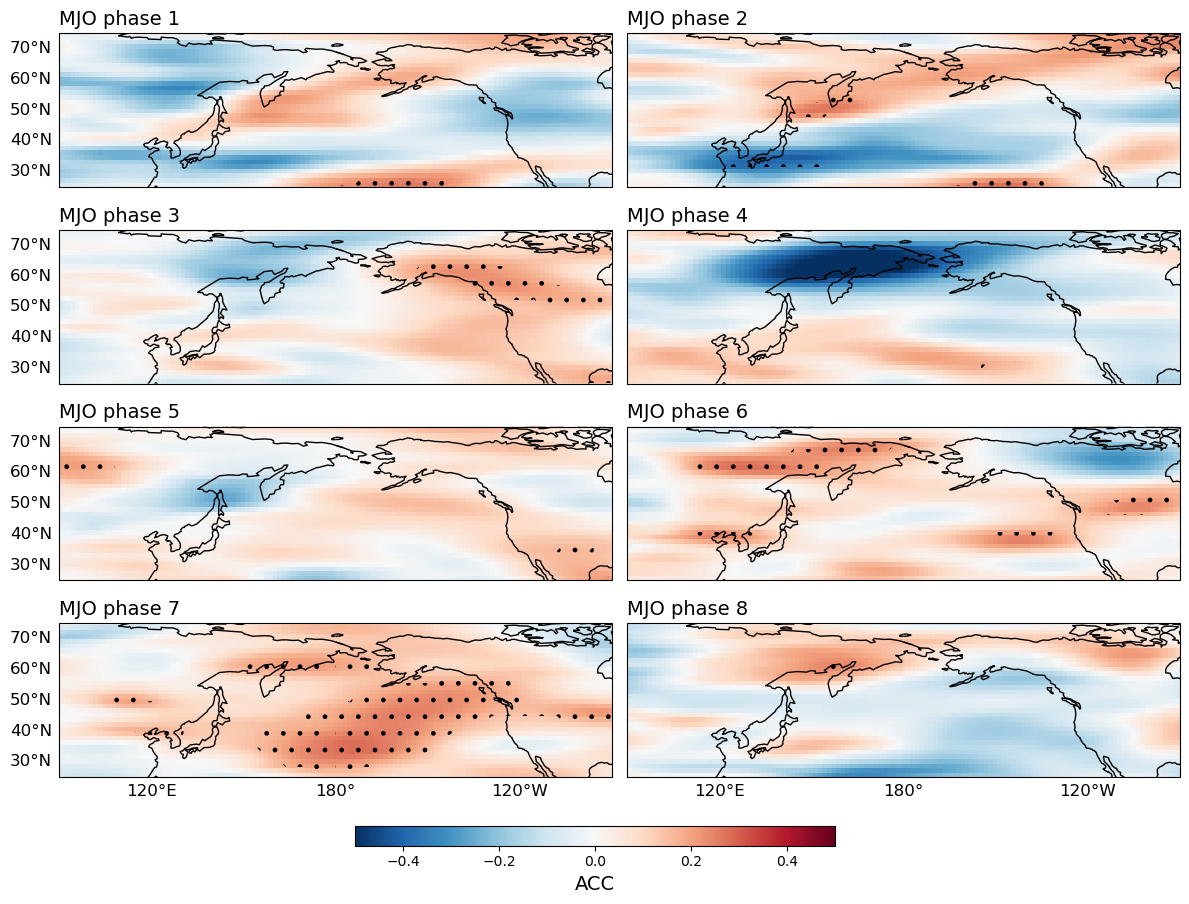

In [38]:
#Plot (no fdr)
for i in range(1):
    fig=plt.figure(figsize=(12,10))
    for j in range(8):
        accphasei=acc_modphases[models11[i]][j].isel(step=slice(6,21)).mean(dim=['step']) - acc_mn[models11[i]].isel(step=slice(6,21)).mean(dim=['step'])


        cm=180
        proj = ccrs.PlateCarree(central_longitude=cm)

        pv=xr.where(sig_mods[models11[i]][j]<0.05,1,np.nan)
        ax1=fig.add_subplot(5,2,j+1,projection=proj)

        ax1.set_xlim([-90,90])
        ax1.set_ylim([-10,90])
        m=accphasei.plot(x='longitude',y='latitude', ax=ax1,vmax=0.5, transform=ccrs.PlateCarree(),add_colorbar=False)#,cbar_kwargs={'label': "Pearson's r",'pad':0.05,"orientation":"horizontal"})
        ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())



        ax1.set_title('')
        ax1.set_title("MJO phase "+str(j+1), fontsize=14,  loc='left')
        gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
        gl.xlabels_top = False
        gl.ylabels_rit2mt = False
        if j%2!=0:
            gl.ylabels_left= False
        if j<6:
            gl.xlabels_bottom = False

        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}

        ax1.set_ylim([25,75])  
        ax1.coastlines()

    cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
    cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
    cbl.set_label(label="ACC",size=14)
    plt.tight_layout()
    #plt.show()
    plt.savefig('plots/acc_mjophases_'+models11[i]+'_diffrommean_bootstrapped_1000x_posneg_nofdr.png')

In [ ]:
#Reopen p values from FDR
sigs=[]
for j in range(8):
    sig=xr.open_dataset('p-vals_mjo_phase'+str(j+1)+'_1000x_fdr.nc')
    sigs.append(sig_new)

In [ ]:
#plot (fdr)
for i in range(1):
    fig=plt.figure(figsize=(12,10))
    for j in range(8):
        accphasei=acc_modphases[models11[i]][j].isel(step=slice(6,21)).mean(dim=['step']) - acc_mn[models11[i]].isel(step=slice(6,21)).mean(dim=['step'])


        cm=180
        proj = ccrs.PlateCarree(central_longitude=cm)

        pv=xr.where(sigs[j]<0.05,1,np.nan)
        ax1=fig.add_subplot(5,2,j+1,projection=proj)

        ax1.set_xlim([-90,90])
        ax1.set_ylim([-10,90])
        m=accphasei.plot(x='longitude',y='latitude', ax=ax1,vmax=0.5, transform=ccrs.PlateCarree(),add_colorbar=False)#,cbar_kwargs={'label': "Pearson's r",'pad':0.05,"orientation":"horizontal"})
        ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())



        ax1.set_title('')
        ax1.set_title("MJO phase "+str(j+1), fontsize=14,  loc='left')
        gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
        gl.xlabels_top = False
        gl.ylabels_rit2mt = False
        if j%2!=0:
            gl.ylabels_left= False
        if j<6:
            gl.xlabels_bottom = False

        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}

        ax1.set_ylim([25,75])  
        ax1.coastlines()

    cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
    cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
    cbl.set_label(label="ACC",size=14)
    plt.tight_layout()
    #plt.show()
    plt.savefig('plots/skill_composites_FDR_MJO.png')

### ENSO

In [17]:
# read ssts
ssts = xr.open_dataset('era5_sst_nino34_region.nc')
ssts=ssts.sel(longitude=slice(-170,-120))
sst_anom=ssts.sst.groupby('valid_time.dayofyear')-ssts.sst.groupby('valid_time.dayofyear').mean()



In [18]:
#smooth for nino 3.4 and get forecast dates
sst_anom_rol=sst_anom.mean(dim=['latitude','longitude']).rolling(valid_time=5).mean().dropna(dim='valid_time')
sst_rol_daily=sst_anom_rol.resample(valid_time='1D').nearest()
sst_initdates=sst_rol_daily.sel(valid_time=sst_rol_daily.valid_time.isin(ob_resampled.time))


In [19]:
#nino 3.4 calculation
sst_elnino=sst_initdates.where(sst_initdates>=0.5).dropna(dim='valid_time')
sst_lanina=sst_initdates.where(sst_initdates<=-0.5).dropna(dim='valid_time')
sst_neutral=sst_initdates.where((sst_initdates<0.5) &(sst_initdates>-0.5) ).dropna(dim='valid_time')

In [21]:
#Get years for each phase
el_dates=sst_elnino.valid_time.values
la_dates=sst_lanina.valid_time.values
ne_dates=sst_neutral.valid_time.values
years_el=[]
for i in el_dates:
    y=i.astype('datetime64[Y]').astype(int)+1970
    years_el.append(y)
all_years_el=list(set(years_el))    

years_la=[]
for i in la_dates:
    y=i.astype('datetime64[Y]').astype(int)+1970
    years_la.append(y)
all_years_la=list(set(years_la)) 

years_ne=[]
for i in ne_dates:
    y=i.astype('datetime64[Y]').astype(int)+1970
    years_ne.append(y)
all_years_ne=list(set(years_ne)) 

In [22]:
#Get exact dates for each ENSO phase
all_years_el.sort()
all_years_la.sort()
all_years_ne.sort()

init_yrs_el={}
for k in all_years_el:
    cur_y=[]
    for i in el_dates:
        y=i.astype('datetime64[Y]').astype(int)+1970
        m=i.astype('datetime64[M]').astype(int) % 12 + 1
        d=pd.to_datetime(i).day
        if y==k:
            cur_y.append(f"{m:02}-{d:02}")
    init_yrs_el[k]=cur_y
            
init_yrs_la={}
for k in all_years_la:
    cur_y=[]
    for i in la_dates:
        y=i.astype('datetime64[Y]').astype(int)+1970
        m=i.astype('datetime64[M]').astype(int) % 12 + 1
        d=pd.to_datetime(i).day
        if y==k:
            cur_y.append(f"{m:02}-{d:02}")
    init_yrs_la[k]=cur_y
    

init_yrs_ne={}
for k in all_years_ne:
    cur_y=[]
    for i in ne_dates:
        y=i.astype('datetime64[Y]').astype(int)+1970
        m=i.astype('datetime64[M]').astype(int) % 12 + 1
        d=pd.to_datetime(i).day
        if y==k:
            cur_y.append(f"{m:02}-{d:02}")
    init_yrs_ne[k]=cur_y
            

In [24]:
#get skill and bootstrap (year swap)
i=0
ob=anom_obs[models11[i]].isel(step=slice(6,21))
fo=anom_models[models11[i]].isel(step=slice(6,21))

o_eln=anom_obs[models11[i]].sel(time=sst_elnino.valid_time.values)
f_eln=anom_models[models11[i]].sel(time=sst_elnino.valid_time.values)

bootdatout_e=bootstrap_sst(fo,ob,init_yrs_el)
bootdat_e=bootdatout_e.mean(dim=['step'])

acc_elnino=acc_fun(f_eln.mean(dim='number'),o_eln)
acc_e=acc_elnino.isel(step=slice(6,21)).mean(dim=['step'])
sige=significance(bootdat_e,acc_e)
bootdat_e.to_netcdf('bootdat_elnino.nc')
sige.to_netcdf('pval_elnino.nc')

o_lan=anom_obs[models11[i]].sel(time=sst_lanina.valid_time.values)
f_lan=anom_models[models11[i]].sel(time=sst_lanina.valid_time.values)

bootdatout_l=bootstrap_sst(fo,ob,init_yrs_la)
bootdat_l=bootdatout_l.mean(dim=['step'])

acc_lanina=acc_fun(f_lan.mean(dim='number'),o_lan)
acc_l=acc_lanina.isel(step=slice(6,21)).mean(dim=['step'])
sigl=significance(bootdat_l,acc_l)
bootdat_l.to_netcdf('bootdat_lanina.nc')
sigl.to_netcdf('pval_lanina.nc')


o_neu=anom_obs[models11[i]].sel(time=sst_neutral.valid_time.values)
f_neu=anom_models[models11[i]].sel(time=sst_neutral.valid_time.values)

bootdatout_n=bootstrap_sst(fo,ob,init_yrs_ne)
bootdat_n=bootdatout_n.mean(dim=['step'])

acc_neutral=acc_fun(f_neu.mean(dim='number'),o_neu)
acc_n=acc_neutral.isel(step=slice(6,21)).mean(dim=['step'])
sign=significance(bootdat_n,acc_n)
bootdat_n.to_netcdf('bootdat_neutral.nc')
sign.to_netcdf('pval_neutral.nc')



In [47]:
#skill difference from mean
acceln=acc_elnino.isel(step=slice(6,21)).mean(dim=['step']) - acc_mean.isel(step=slice(6,21)).mean(dim=['step'])
acclan=acc_lanina.isel(step=slice(6,21)).mean(dim=['step']) - acc_mean.isel(step=slice(6,21)).mean(dim=['step'])
accneu=acc_neutral.isel(step=slice(6,21)).mean(dim=['step']) - acc_mean.isel(step=slice(6,21)).mean(dim=['step'])

In [52]:
#save significance to files
sige.to_netcdf('p-values_elnino.nc')
sigl.to_netcdf('p-values_lanina.nc')
sign.to_netcdf('p-values_neutral.nc')

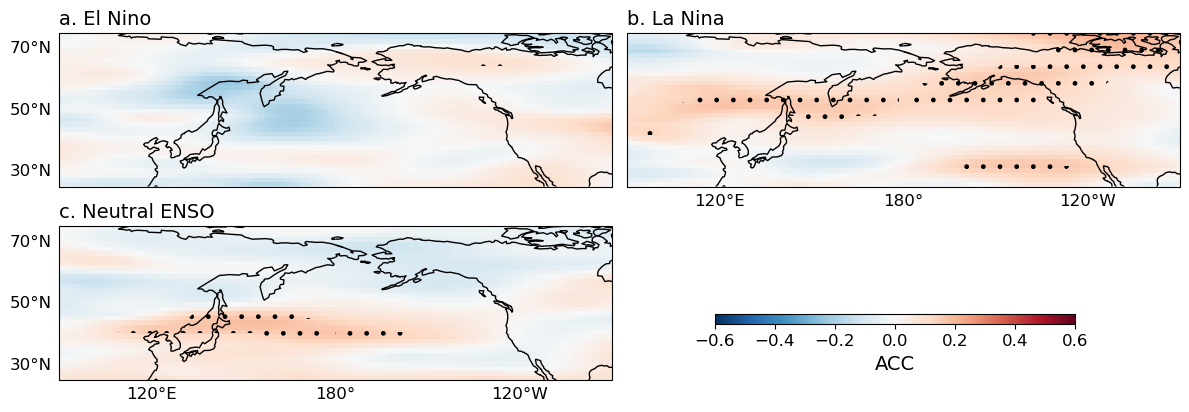

In [49]:
#plot (no fdr)


fig=plt.figure(figsize=(12,5))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)
pv=xr.where(sige<0.05,1,np.nan)

ax1=fig.add_subplot(221,projection=proj)

ax1.set_xlim([-90,90])
ax1.set_ylim([25,75])  
acceln.plot(x='longitude',y='latitude', ax=ax1,vmax=0.6, transform=ccrs.PlateCarree(),  add_colorbar=False)#,cbar_kwargs={'label': "Pearson's r",'pad':0.05,"orientation":"horizontal"})
ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())


ax1.set_title('')
ax1.set_title('a. El Nino ', fontsize=14,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_rit2mt = False
gl.xlabels_bottom = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax1.coastlines()

ax1=fig.add_subplot(222,projection=proj)

pv=xr.where(sigl<0.05,1,np.nan)

ax1.set_xlim([-90,90])
ax1.set_ylim([25,75])  
acclan.plot(x='longitude',y='latitude', ax=ax1, vmax= 0.6,transform=ccrs.PlateCarree(),  add_colorbar=False)
ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())



ax1.set_title('')
ax1.set_title('b. La Nina ', fontsize=14,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_rit2mt = False
gl.ylabels_left = False
# gl.xlabels_bottom = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax1.coastlines()

ax1=fig.add_subplot(223,projection=proj)

pv=xr.where(sign<0.05,1,np.nan)

ax1.set_xlim([-90,90])
ax1.set_ylim([25,75])  
m=accneu.plot(x='longitude',y='latitude', ax=ax1, vmax= 0.6,transform=ccrs.PlateCarree(),  add_colorbar=False)
ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())



ax1.set_title('')
ax1.set_title('c. Neutral ENSO', fontsize=14,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_rit2mt = False


gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax1.coastlines()

cbar_ax = fig.add_axes([0.6, 0.35, 0.3, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="ACC",size=14)
cbl.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, bottom=0.2)


plt.savefig('skill_composites_ENSO.png')

In [ ]:
#Read pvalues after fdr
sige=xr.open_dataset('p-val_elnino_fdr.nc').q
sigl=xr.open_dataset('p-val_lanina_fdr.nc').q
sign=xr.open_dataset('p-val_neutral_fdr.nc').q

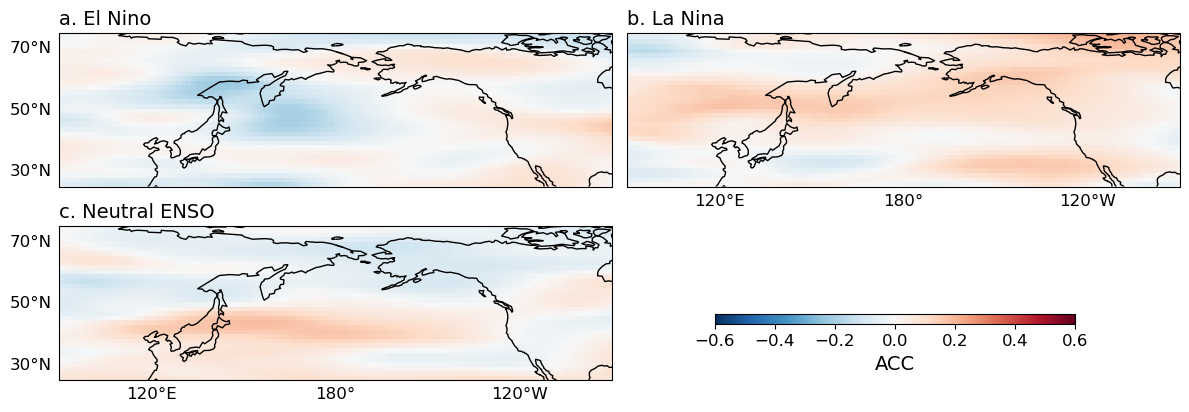

In [57]:
#plot  (fdr)


fig=plt.figure(figsize=(12,5))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)
pv=xr.where(sige<0.05,1,np.nan)

ax1=fig.add_subplot(221,projection=proj)

ax1.set_xlim([-90,90])
ax1.set_ylim([25,75])  
acceln.plot(x='longitude',y='latitude', ax=ax1,vmax=0.6, transform=ccrs.PlateCarree(),  add_colorbar=False)#,cbar_kwargs={'label': "Pearson's r",'pad':0.05,"orientation":"horizontal"})
ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())


ax1.set_title('')
ax1.set_title('a. El Nino ', fontsize=14,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_rit2mt = False
gl.xlabels_bottom = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax1.coastlines()

ax1=fig.add_subplot(222,projection=proj)

pv=xr.where(sigl<0.05,1,np.nan)

ax1.set_xlim([-90,90])
ax1.set_ylim([25,75])  
acclan.plot(x='longitude',y='latitude', ax=ax1, vmax= 0.6,transform=ccrs.PlateCarree(),  add_colorbar=False)
ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())



ax1.set_title('')
ax1.set_title('b. La Nina ', fontsize=14,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_rit2mt = False
gl.ylabels_left = False
# gl.xlabels_bottom = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax1.coastlines()

ax1=fig.add_subplot(223,projection=proj)

pv=xr.where(sign<0.05,1,np.nan)

ax1.set_xlim([-90,90])
ax1.set_ylim([25,75])  
m=accneu.plot(x='longitude',y='latitude', ax=ax1, vmax= 0.6,transform=ccrs.PlateCarree(),  add_colorbar=False)
ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())



ax1.set_title('')
ax1.set_title('c. Neutral ENSO', fontsize=14,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_rit2mt = False


gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax1.coastlines()

cbar_ax = fig.add_axes([0.6, 0.35, 0.3, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="ACC",size=14)
cbl.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, bottom=0.2)


plt.savefig('skill_composites_FDR_ENSO.png')

## SSWs

In [25]:
#read u10 data
years=np.unique(ob_resampled.time.dt.year.values)
u10_zonals=[]
for y in years:
    u10_c=xr.open_dataset('u10/era5_u10_'+str(y)+'_daily_1x1.nc')
    u_mean=u10_c.u.sel(latitude=60,pressure_level=10,method='nearest').mean(dim='longitude')
    u10_zonals.append(u_mean)
u10_zonal=xr.concat(u10_zonals,dim='valid_time')

In [26]:
# Find ssw initialization dates (20days westerly+ reversal+ 10days westerly before april 30)
ssw_dates=[]
for y in years:
    if y!=2021:
        udates=u10_zonal.sel(valid_time=slice(str(y)+'-11-01',str(y+1)+'-04-30'))
        dat=udates.values
        dates=udates.valid_time.values
    else:
        pass
    
    for i in range(20,len(dat)-10):
        if dat[i-1]>0 and dat[i]<0:
            
            if np.all(dat[i-20:i]>0):
                num_west=0
                j=i+1
                while j <(len(dat)):
                    if dat[j]>0:
                        num_west=num_west+1
                    else:
                        num_west=0
                        
                    if num_west>=10:
                        ssw_dates.append(dates[i])
                        break
                    j=j+1
ssw_days=np.array(ssw_dates)                

In [29]:
#Get 10 days right after SSW initiation
ssw_plus10=[]
for i in ssw_days:
    ssw_plus10.append(i)
    for j in range(1,11):
        day=i+np.timedelta64(j, 'D')
        ssw_plus10.append(day)
        

In [30]:
#Select forecast dataset within 10days of SSW initiation
mask=np.isin(ob_resampled.time.values,ssw_plus10)
ssw_initdates=ob_resampled.time.values[np.where(mask)]

In [31]:
#Get ssw years
years=[]
for i in ssw_initdates:
    y=i.astype('datetime64[Y]').astype(int)+1970
    years.append(y)
all_years=list(set(years))    

In [32]:
#Get exact ssw dates
all_years.sort()
init_yrs={}
for k in all_years:
    cur_y=[]
    for i in ssw_initdates:
        y=i.astype('datetime64[Y]').astype(int)+1970
        m=i.astype('datetime64[M]').astype(int) % 12 + 1
        d=pd.to_datetime(i).day
        if y==k:
            cur_y.append(f"{m:02}-{d:02}")
    init_yrs[k]=cur_y
            
    

In [ ]:
#skill and bootstrap on ssw dates 
i=0
o_ssw=anom_obs[models11[i]].sel(time=ssw_initdates)
f_ssw=anom_models[models11[i]].sel(time=ssw_initdates)

bootdatout_ssw=bootstrap_ssw(fo,ob,init_yrs)
bootdat_ssw=bootdatout_ssw.mean(dim=['step'])

acc_ssw=acc_new(f_ssw.mean(dim='number'),o_ssw)
acc_sw=acc_ssw.isel(step=slice(6,21)).mean(dim=['step'])
sig_ssw=significance(bootdat_ssw,acc_sw)

acc_ssw_plot=acc_sw- acc_mean.isel(step=slice(6,21)).mean(dim=['step'])

In [55]:
#save pvalues
sig_ssw.to_netcdf('pval_ssw.nc')

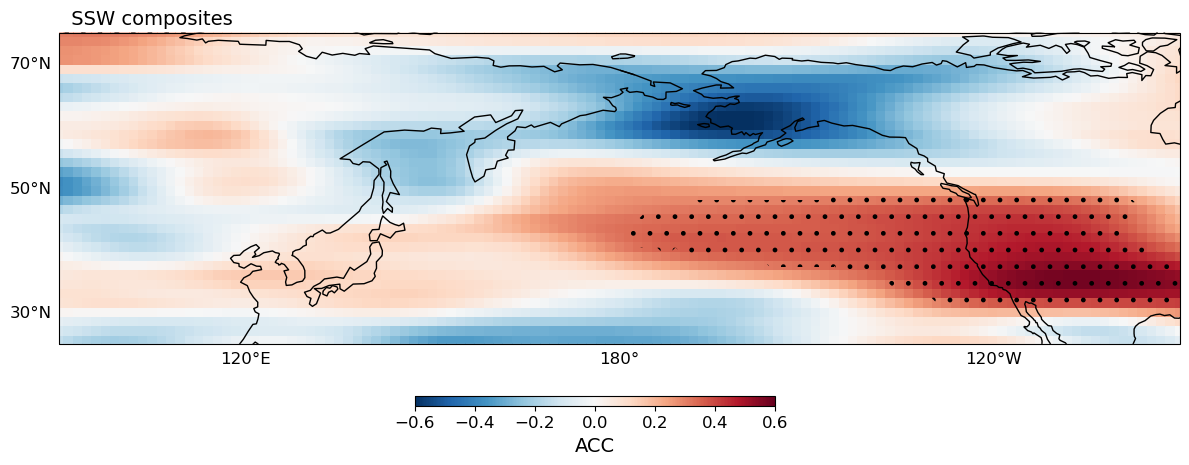

In [59]:
#Plot (no fdr)
fig=plt.figure(figsize=(12,5))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)
pv=xr.where(sige<0.05,1,np.nan)


ax1=fig.add_subplot(111,projection=proj)

pv=xr.where(sig_ssw<0.05,1,np.nan)

ax1.set_xlim([-90,90])
ax1.set_ylim([25,75])  
m=acc_ssw_plot.plot(x='longitude',y='latitude', ax=ax1, vmax= 0.6,transform=ccrs.PlateCarree(),  add_colorbar=False)
ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())



ax1.set_title('')
ax1.set_title('  SSW composites', fontsize=14,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_rit2mt = False


gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax1.coastlines()

cbar_ax = fig.add_axes([0.35, 0.15, 0.3, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="ACC",size=14)
cbl.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, bottom=0.2)

plt.savefig('skill_composites_SSW.png')

In [63]:
#read pvalues after fdr
sig_ssw=xr.open_dataset('p-val_ssw_fdr.nc').q

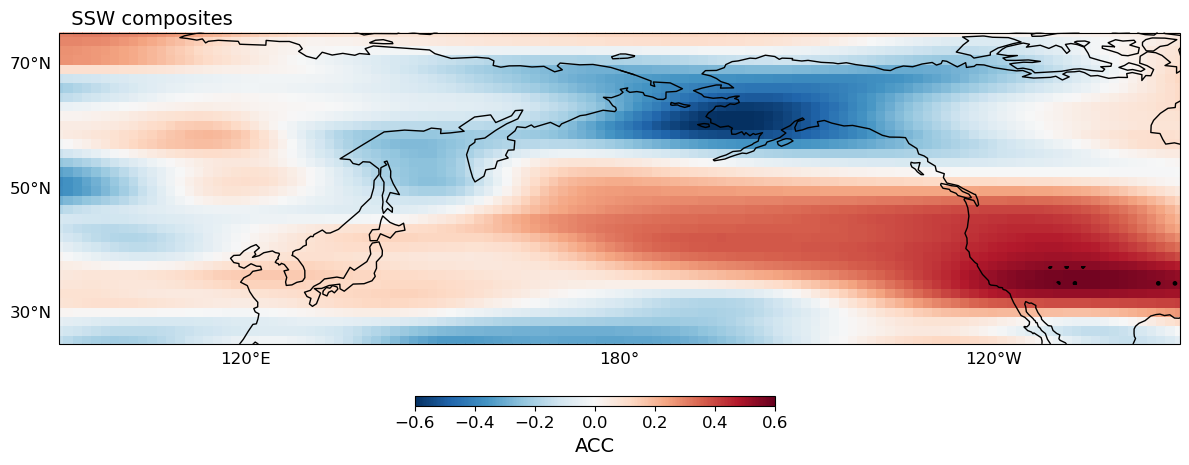

In [64]:
#Plot (fdr)
fig=plt.figure(figsize=(12,5))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)
pv=xr.where(sige<0.05,1,np.nan)


ax1=fig.add_subplot(111,projection=proj)

pv=xr.where(sig_ssw<0.05,1,np.nan)

ax1.set_xlim([-90,90])
ax1.set_ylim([25,75])  
m=acc_ssw_plot.plot(x='longitude',y='latitude', ax=ax1, vmax= 0.6,transform=ccrs.PlateCarree(),  add_colorbar=False)
ax1.contourf(pv.longitude.values,pv.latitude.values,pv.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())



ax1.set_title('')
ax1.set_title('  SSW composites', fontsize=14,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_rit2mt = False


gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax1.coastlines()

cbar_ax = fig.add_axes([0.35, 0.15, 0.3, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="ACC",size=14)
cbl.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, bottom=0.2)

plt.savefig('skill_composites_FDR_SSW.png')